# E. coli Glycolytic Network Construction
## Growth Medium: Glucose
Growth data obtained from the following sources: 
- Gerosa, Luca et al. “Pseudo-transition Analysis Identifies the Key Regulators of Dynamic Metabolic Adaptations from Steady-State Data.” Cell systems vol. 1,4 (2015): 270-82. doi:10.1016/j.cels.2015.09.008


- Volkmer, Benjamin, and Matthias Heinemann. “Condition-dependent cell volume and concentration of Escherichia coli to facilitate data conversion for systems biology modeling.” PloS one vol. 6,7 (2011): e23126. doi:10.1371/journal.pone.0023126


### Import packages

In [25]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass


import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt

import cobra
from cobra.io.json import load_json_model as load_cobra_json_model

import mass
from mass import MassConfiguration, MassModel, MassMetabolite, MassReaction, Simulation
from mass.io.json import save_json_model as save_mass_json_model
from mass.visualization import plot_comparison, plot_time_profile


print(f"COBRApy version: {cobra.__version__}")
print(f"MASSpy version: {mass.__version__}")

COBRApy version: 0.23.0
MASSpy version: 0.1.7


### Set solver

In [26]:
MASSCONFIGURATION = MassConfiguration()
MASSCONFIGURATION.solver = "gurobi"

## Load COBRA model

In [27]:
cobra_model = load_cobra_json_model("./models/cobra/iML1515.json")

## Obtain Flux State
### Load growth data

In [28]:
medium = "Glucose"
'''
flux_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="flux_data",
    index_col=0
)
'''
flux_data = pd.read_excel(
    # io="./data/growth_data_extended.xlsx",
    io="./data/growth_data.xlsx",
    # sheet_name="flux_data_reduced",
    sheet_name="flux_data",
    index_col=0
)
flux_data = flux_data.loc[lambda x: x['Growth Medium'] == medium]
flux_data = flux_data.drop("Growth Medium", axis=1)
flux_data

,Flux (mmol * gDW-1 * h-1)
ID,
EX_ac_e,6.827019e+00
ACt2rpp,-6.827019e+00
ACKr,-6.827019e+00
PTAr,6.827019e+00
ACS,0.000000e+00
...,...
ME1,-4.778621e-08
ME2,-4.778621e-08
ICL,9.654038e-10


### Set bounds
#### Growth rate and media

In [29]:
biomass_rxn = cobra_model.reactions.BIOMASS_Ec_iML1515_core_75p37M
growth_rate = flux_data.loc[biomass_rxn.id][0] #This index is hard-coded based on which column has the flux value
biomass_rxn.bounds = (0, growth_rate)
biomass_rxn.bounds

(0, 0.65)

In [30]:
EX_glc__D_e = cobra_model.reactions.EX_glc__D_e
medium_uptake = flux_data.loc[EX_glc__D_e.id][0] #This index is hard-coded based on which column has the flux value
EX_glc__D_e.bounds = (medium_uptake, 0)
EX_glc__D_e.bounds

(-9.654, 0)

### Formulate QP minimization for fluxes

In [31]:
v_vars = []
v_data = []

# For irreversible enzyme pairs, flux data is given as Enzyme1 - Enzyme2 = value.
# To ensure all enzymes have some flux, add a percentage of the net flux for each enzyme
# The netflux will still remain the same value.
reverse_flux_percent = 0.1

irreversible_enzyme_pairs = [["PFK", "FBP"], ["PYK", "PPS"]]

for rid, flux in flux_data.itertuples():
    # Make adjustments to net flux of PFK/FBP and PYK/PPS to ensure
    # no target flux value is 0 in order to create an enzyme module.
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_data.loc[irreversible_enzyme_pair, "Flux (mmol * gDW-1 * h-1)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
            print(rid, flux)
            
    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)
F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
cobra_model.objective = objective[0]
cobra_model.objective_direction = "min"

flux_solution = cobra_model.optimize()
flux_solution

PFK 7.76432470140912
FBP 0.7058477001281019
PYK 2.7360389076214697
PPS 0.24873080978377


,fluxes,reduced_costs
CYTDK2,0.000000,0.0
XPPT,0.000000,0.0
HXPRT,0.000000,0.0
NDPK5,0.013807,0.0
SHK3Dr,0.194777,0.0
...,...,...
MPTS,0.000000,0.0
MOCOS,0.000000,0.0
BMOGDS2,0.000000,0.0
FESD2s,0.000000,0.0


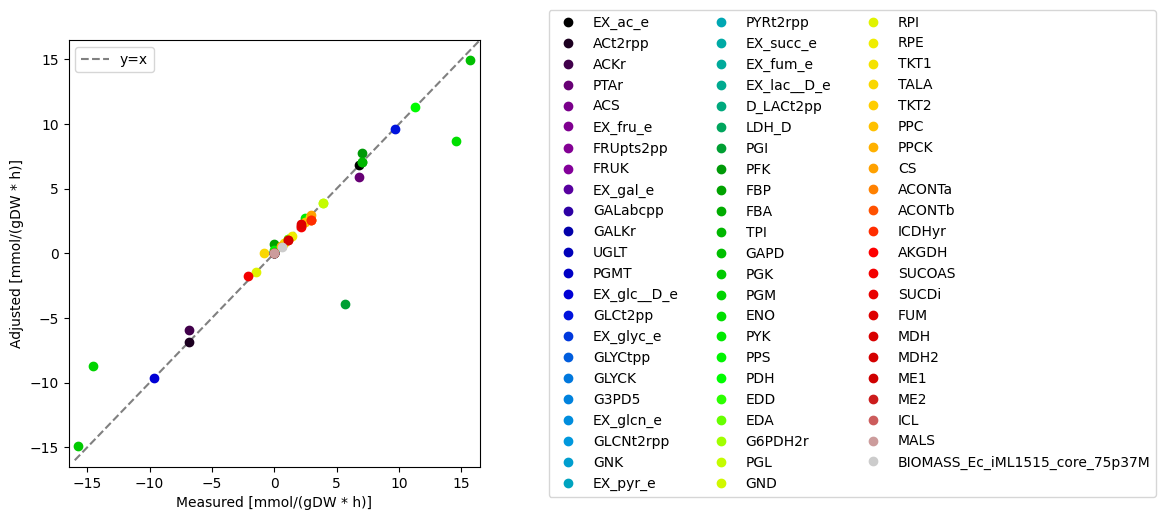

In [32]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_data["Flux (mmol * gDW-1 * h-1)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_data.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-16.5, 16.5), ylim=(-16.5, 16.5),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()

#### Export data for analysis

In [33]:
flux_data_for_comparison = pd.concat(objs=(flux_data, flux_solution.fluxes), axis=1).dropna()
flux_data_for_comparison.index.name = "ID"
flux_data_for_comparison.columns = ["Initial", "Adjusted"]
flux_data_for_comparison.to_csv("./data/analysis_data/fluxes_extended.csv")

## Create MASS Model

In [34]:
# Create MassModel
mass_model = MassModel("CentralMetabolism", array_type="DataFrame")

# Reactions to extract into subnetwork
reaction_list = [
    "GLCptspp",
"PGI",
"PFK",
"FBP",
"FBA",
"TPI",
"GAPD",
"PGK",
"PGM",
"ENO",
"PYK",
"PPS",
"G6PDH2r",
"PGL",
"GND",
"RPE",
"RPI",
"TKT1",
"TKT2",
"TALA",
"LDH_D",
"D_LACt2pp",
"PYRt2rpp",
"PFL",
"PTAr",
"ACKr",
"ACt2rpp",
"ACALD",
"ACALDtpp",
"ALCD2x",
"ETOHtrpp",
"PDH",
"OAADC",
"PPC",
"PPCK",
"ME1",
"ME2",
"SUCCt1pp",
"AKGt2rpp",
"CS",
"ACONTa",
"ACONTb",
"ICDHyr",
"AKGDH",
"SUCOAS",
"SUCDi",
"FUM",
"MDH",
"MDH2",
"ICL",
"MALS",
"PGMT",
"G3PD2",
"HCO3E",
"CO2tpp",
"PPA",
"CAT",
"SPODM",
"SPODMpp",
"ATPM",
"ATPS4rpp",
"THD2pp",
"NADTRHD",
"NADH16pp",
"FDH4pp",
"NADPHQR2",
"NADH5",
"LDH_D2",
"POX",
"G3PD5",
"L_LACD2",
"CYTBO3_4pp",
"CYTBDpp",
]

cobra_reactions = cobra_model.reactions.get_by_any(reaction_list)
mass_model.add_reactions([MassReaction(rxn) for rxn in cobra_reactions])
mass_model

Name,CentralMetabolism
Memory address,0x028dbeba6148
Stoichiometric Matrix,70x73
Matrix Rank,58
Number of metabolites,70
Initial conditions defined,0/70
Number of reactions,73
Number of genes,68
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Convert flux units to M/s

In [35]:
T = 313.15
gas_constant = 0.008314
e_coli_density = 1.1 # g / mL assumption
volume = 3.2  # femtoliter

# Perform conversions
doubling_time_per_minute = np.log(2) / growth_rate * 60
cell_gDW = 42000 * doubling_time_per_minute**-1.232 * 1e-15
real_cell_total_weight = e_coli_density * (volume * 1e-12) # fL --> mL

# Assume water is 70%
adj_volume = volume * 0.7
gDW_L_conversion_factor = real_cell_total_weight / (adj_volume * 1e-15)

for reaction in mass_model.reactions.get_by_any(reaction_list):
    flux = flux_solution[reaction.id]
    reaction.steady_state_flux = flux * gDW_L_conversion_factor * 0.001 / 3600 

## Set equilibrium constants

In [36]:
Keq_data = pd.read_excel(
    io="./data/growth_data.xlsx",
    sheet_name="Keq_data",
    index_col=0
)
for reaction in mass_model.reactions.get_by_any(reaction_list):
    reaction.Keq = Keq_data.loc[reaction.Keq_str][0]

KeyError: 'Keq_GLCptspp'

In [13]:
conc_data = pd.read_excel(
    io="./data/growth_data.xlsx",
    sheet_name="conc_data",
    index_col=0
)
conc_data = conc_data.loc[lambda x: x['Growth Medium'] == "Glucose"]
conc_data = conc_data.drop("Growth Medium", axis=1)
conc_data

,Concentration (mol * L-1)
ID,
adp_c,0.002185
amp_c,0.001743
atp_c,0.012466
nad_c,0.007636
nadh_c,0.000099
13dpg_c,0.000184
f6p_c,0.001214
dhap_c,0.004772
g6p_c,0.003431


### Add PFK1 activator GDP

In [14]:
#gdp_c = MassMetabolite(cobra_model.metabolites.gdp_c)
# Set the activator as a constant
#gdp_c.fixed = True

#mass_model.add_metabolites(gdp_c)

### Set initial concentrations from growth data

In [15]:
mass_model.update_initial_conditions({
    mid: value for mid, value in conc_data.itertuples()
})

# Fix hydrogen and water as constants and set concentration to 1.
for metabolite in mass_model.metabolites.get_by_any(["h2o_c", "h_c"]):
    metabolite.fixed = True
    metabolite.initial_condition = 1

missing_ics = mass_model.metabolites.query(lambda m: m.initial_condition is None)
# Provide initial guesses for missing metabolites (pi_c, g3p_c, and lac__D_c)
print(missing_ics)
for metabolite in missing_ics:
    metabolite.initial_condition = 0.001

[<MassMetabolite glc__D_p at 0x251106e34c0>, <MassMetabolite 6pgl_c at 0x251106da4c0>, <MassMetabolite lac__D_c at 0x251106ec970>, <MassMetabolite h_p at 0x251106ecaf0>, <MassMetabolite lac__D_p at 0x251106ecbb0>, <MassMetabolite pyr_p at 0x251106ecd30>, <MassMetabolite ac_p at 0x251106e95b0>, <MassMetabolite acald_c at 0x251106e9730>, <MassMetabolite acald_p at 0x251106e9970>, <MassMetabolite etoh_c at 0x251106e99a0>, <MassMetabolite etoh_p at 0x251106e9ca0>, <MassMetabolite succ_p at 0x251106dc8e0>, <MassMetabolite akg_p at 0x251106dc9a0>, <MassMetabolite glx_c at 0x251106dde80>, <MassMetabolite co2_p at 0x251106df7c0>, <MassMetabolite h2o2_c at 0x251106dfa60>, <MassMetabolite o2s_c at 0x251106dfd00>, <MassMetabolite h2o2_p at 0x251106dfe50>, <MassMetabolite o2_p at 0x251106dff70>, <MassMetabolite o2s_p at 0x251106dfee0>, <MassMetabolite for_p at 0x251106e0c10>, <MassMetabolite lac__L_c at 0x251106e2e50>]


mass\core\mass_model.py:1967 UserWarning: No metabolite found for '10fthf_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '23dhb_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2ddg6p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2dmmql8'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2dr5p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '4abut_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '4hbz_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '5mthf'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'aacoa_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'acgam1p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'acorn_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'ade_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'adn_c'
mass\core\mass_

### Formulate QP minimization for concentrations

In [16]:
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

In [17]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_feasible_qp_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
g6p_c,2.958072e-03,0.0
glc__D_p,1.000000e-03,0.0
pep_c,1.737807e-06,0.0
pyr_c,1.092080e-04,0.0
f6p_c,3.642845e-04,0.0
...,...,...
Keq_POX,5.638934e+15,0.0
Keq_G3PD5,8.369585e+07,0.0
Keq_L_LACD2,2.059113e+06,0.0
Keq_CYTBO3_4pp,2.128717e+15,0.0


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'gal1p_c', 'val__L_c', 'adocbl', 'gln__L_c', 'mql8', 'clpn161', 'uacgam_c', 'itp_c', 'spmd_c', '5mthf', 'gtp_c', 'phe__L_c', 'pheme', 'adn_c', 'crn_c', 'dgmp_c', 'lys__L_c', 'thmpp', 'glu__L_c', 'skm_c', 'phpyr_c', 'mlthf', 'ctp_c', 'dttp_c', 'pydx5p', 'imp_c', 'met__L_c', 'pe161', 'trp__L_c', 'ura_c', 'dhor__S_c', 'acgam1p_c', 'ser__L_c', 'dtdp_c', 'gthox_c', 'malcoa', 'aps_c', 'tyr__L_c', 'mobd', '2dr5p_c', 'quln_c', 'fad_c', 'cmp_c', 'his__L_c', 'dgsn_c', 'adpglc_c', '4abut_c', 'mnl1p_c', 'chor', 'gmp_c', '2dmmql8', 'mococdp', 'ala_B_c', 'h_c', 'histd_c', 'ala__L_c', 'csn_c', 'clpn160', 'orn_c', 'idp_c', 'glyc__R_c', 'inost_c', 'pro__L_c', 'pe181', 'thf', 'pg181', 'udcpdp', 'hemeO', 'sheme', 'gam6p_c', 'cytd_c', 'man6p_c', '2ddg6p_c', 'cys__L_c', 'datp_c', 'btn', '4hbz_c', 'ile__L_c', 'prpp_c', 'pg161', 'asn__L_c', 'hcys__L_c', 'glcn_c', 'mocogdp', 'gdp_c', 'tre6p_c', 'enter', '10fthf_c', 'udpglcur_c', 'ribflv_c', 

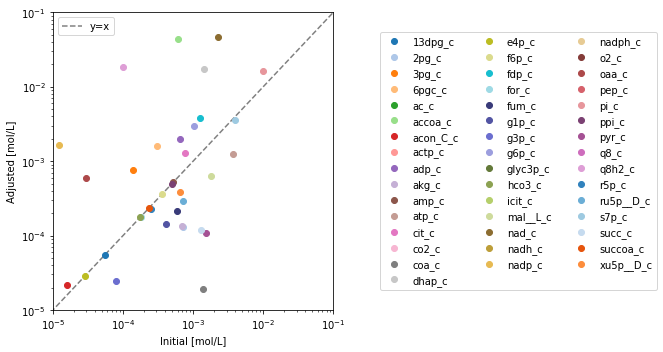

In [18]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_data["Concentration (mol * L-1)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_data.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e-1), ylim=(1e-5, 1e-1), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [19]:
conc_data_for_comparison = pd.concat(objs=(conc_data, conc_solution.concentrations), axis=1).dropna()
conc_data_for_comparison.index.name = "ID"
conc_data_for_comparison.columns = ["Initial", "Adjusted"]
conc_data_for_comparison.to_csv("./data/analysis_data/concentrations_extended.csv")
conc_data_for_comparison

,Initial,Adjusted
ID,,
13dpg_c,0.000055,5.507545e-05
2pg_c,0.000725,1.312710e-04
3pg_c,0.000138,7.623383e-04
6pgc_c,0.000302,1.575748e-03
ac_c,0.000660,4.405418e+04
accoa_c,0.000606,4.317167e-02
acon_C_c,0.000016,2.197753e-05
actp_c,0.001070,4.437560e-01
adp_c,0.000656,1.981738e-03


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'Keq_CHTBStex', 'Keq_ENTCS', 'Keq_UREAtex', 'Keq_THRt4pp', 'Keq_G3PAT141', 'Keq_KDOCT2', 'Keq_NADPPPS', 'Keq_EX_tartr__D_e', 'Keq_XYLUtex', 'Keq_PTA2', 'Keq_THRD_L', 'Keq_FUMtex', 'Keq_FACOAL180t2pp', 'Keq_THIORDXi', 'Keq_OP4ENH', 'Keq_EX_dad_2_e', 'Keq_DAGK160', 'Keq_DXYLONtex', 'Keq_MNLptspp', 'Keq_GLCRt2rpp', 'Keq_PE181abcpp', 'Keq_NDPK7', 'Keq_DURIK1', 'Keq_SELR', 'Keq_G5SADs', 'Keq_PLIPA2A161pp', 'Keq_CYNTAH', 'Keq_DHCINDO', 'Keq_GALURtex', 'Keq_FRUpts2pp', 'Keq_EX_malthx_e', 'Keq_MDDCP2pp', 'Keq_MALTTTRabcpp', 'Keq_PSSA181', 'Keq_RNTR2c2', 'Keq_PLIPA2A181pp', 'Keq_GALCTND', 'Keq_EPMEACPR', 'Keq_MPTSS', 'Keq_3HAD121', 'Keq_HEPT1', 'Keq_CU2tpp', 'Keq_EX_cit_e', 'Keq_2AGPG180tipp', 'Keq_NTP5', 'Keq_EX_fe3dcit_e', 'Keq_AGPAT140', 'Keq_LPLIPAL2ATE180', 'Keq_NTP3', 'Keq_FTHFLi', 'Keq_PRASCSi', 'Keq_CITtex', 'Keq_LPLIPAL1E140pp', 'Keq_GLNS', 'Keq_ABUTD', 'Keq_RBFSa', 'Keq_TYRPtex', 'Keq_AB6PGH', 'Keq_G6Ptex', 'Keq_TYRP

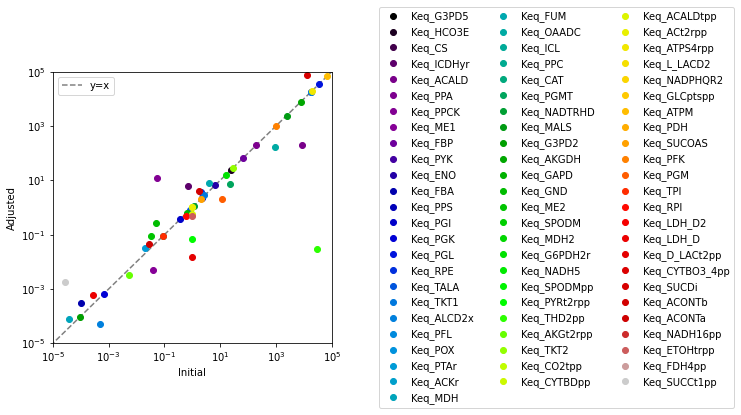

In [20]:
Keq_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

plot_comparison(
    x=Keq_data["Equilibrium Constant"], y=conc_solution,
    compare="Keqs", ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), xy_line=True,
    xy_legend="best", xlabel="Initial", ylabel="Adjusted")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [21]:
Keq_data_for_comparison = pd.concat(objs=(Keq_data, conc_solution.Keqs), axis=1).dropna()
Keq_data_for_comparison.index.name = "ID"
Keq_data_for_comparison.columns = ["Initial", "Adjusted"]
Keq_data_for_comparison.to_csv("./data/analysis_data/equilibrium_constants_extended.csv")
Keq_data_for_comparison

,Initial,Adjusted
ID,,
Keq_G3PD5,3.097852e+09,8.369585e+07
Keq_HCO3E,2.352797e+01,2.352797e+01
Keq_CS,4.465331e+06,4.465331e+06
Keq_ICDHyr,7.288431e-01,5.963550e+00
Keq_ACALD,8.884664e+03,2.003046e+02
...,...,...
Keq_ACONTa,2.777306e-02,4.665965e-02
Keq_NADH16pp,4.079883e+06,1.764575e+13
Keq_ETOHtrpp,1.000000e+00,4.730358e-01


In [22]:
# Fix Metabolite IDs as SBML compatible before next step
for metabolite in mass_model.metabolites:
    if metabolite.id[0].isdigit():
        metabolite.id = f"_{metabolite.id}"
mass_model.repair()

In [40]:
from pprint import pprint
pprint(vars(mass_model.metabolites.co2_c))

{'_annotation': {'bigg.metabolite': ['co2'],
                 'biocyc': ['META:CARBON-DIOXIDE'],
                 'chebi': ['CHEBI:23011',
                           'CHEBI:3283',
                           'CHEBI:48829',
                           'CHEBI:16526',
                           'CHEBI:13283',
                           'CHEBI:13285',
                           'CHEBI:13284',
                           'CHEBI:13282'],
                 'envipath': ['650babc9-9d68-4b73-9332-11972ca26f7b/compound/2ec3da94-5f50-4525-81b1-5607c5c7a3d3',
                              '32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/compound/05f60af4-0a3f-4ead-9a29-33bb0f123379'],
                 'hmdb': ['HMDB01967'],
                 'inchi_key': ['CURLTUGMZLYLDI-UHFFFAOYSA-N'],
                 'kegg.compound': ['C00011'],
                 'kegg.drug': ['D00004'],
                 'metanetx.chemical': ['MNXM13'],
                 'reactome.compound': ['29376',
                                       '56685

In [39]:
#Set the metabolite for CO2 as a fixed metabolite using the "fixed" attribute (e.g., co2_c.fixed = True, etc.)
mass_model.metabolites.co2_c.fixed = True
mass_model.metabolites.co2_c.initial_condition = 0.001

In [41]:
n_models = 2

In [42]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)
for variable in conc_solver.variables:
    try:
        met = mass_model.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=4)
conc_samples

OptimizationError: CVA warmup found no feasible solutions. Ensure the systems has the appropriate variables and constraints by excluding certain metabolites (e.g. hydrogen) and reactions (e.g. boundary reactions), and by indicating the equilibrium reactions.

### Balance network with pseudoreactions and calculate PERCs

In [25]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = mass_model.copy()
    new_model.id += "_C{0:d}".format(idx)
    print(f"Creating model {new_model.id}")
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)
    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Creating model CentralMetabolism_C0
Creating model CentralMetabolism_C1
Number of models in ensemble: 2


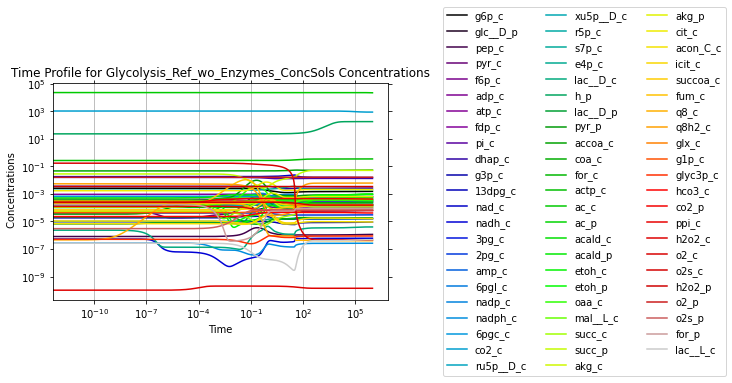

In [28]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(reference_model, time=(0, tfinal))
conc_sol_orig.view_time_profile()

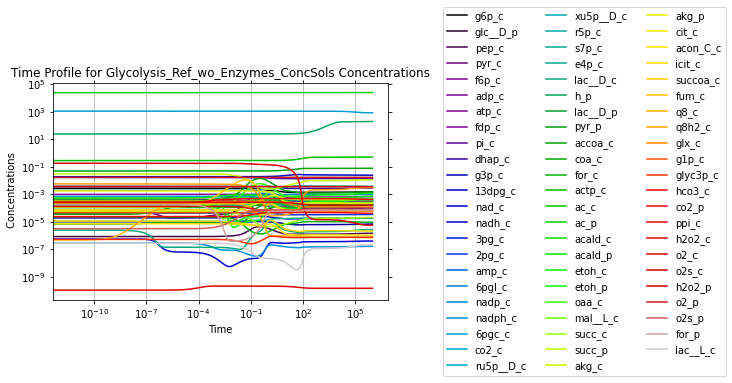

In [29]:
conc_sol_pert, flux_sol_pert = sim.simulate(
    reference_model, time=(0, tfinal), perturbations={"kf_CS": "kf_CS * 0.05"})
conc_sol_pert.view_time_profile()

In [30]:
#Citrate should deplete
print("Citrate WT is: " + str(conc_sol_orig.cit_c[-1]))
print("Citrate with CS inhibited is: " + str(conc_sol_pert.cit_c[-1]))

#succoa should deplete
print("Succoa WT is: " + str(conc_sol_orig.succoa_c[-1]))
print("Succoa with CS inhibited is: " + str(conc_sol_pert.succoa_c[-1]))

#Malate should accumulate
print("Malate WT is: " + str(conc_sol_orig.mal__L_c[-1]))
print("Malate with CS inhibited is: " + str(conc_sol_pert.mal__L_c[-1]))

#accoa should accumulate
print("Accoa original is: " + str(conc_sol_orig.accoa_c[-1]))
print("Accoa original is: " + str(conc_sol_pert.accoa_c[-1]))

Citrate WT is: 0.0020582786930587746
Citrate with CS inhibited is: 0.00020266784883631828
Succoa WT is: 0.00016616005608121895
Succoa with CS inhibited is: 6.43026469187652e-05
Malate WT is: 0.00042559343475320516
Malate with CS inhibited is: 0.0002490542373391568
Accoa original is: 0.054715005586985124
Accoa original is: 0.07487970128718137


#### Save a reference MASS model w/o enzymes

In [27]:
conc_sol, flux_sol = sim.find_steady_state(
    models=reference_model, strategy="simulate", 
    tfinal=tfinal)
if conc_sol and flux_sol:
    reference_model.update_initial_conditions(conc_sol)
    reference_model.update_parameters({f"v_{k}": v for k, v in flux_sol.items()})
    # Save a reference MASS model
    save_mass_json_model(
        mass_model=reference_model,
        filename=f"./models/mass/without_enzymes/{reference_model.id}.json")
    print(f"Saving {reference_model.id}")
reference_model

Saving Glycolysis_Ref_wo_Enzymes


Name,Glycolysis_Ref_wo_Enzymes
Memory address,0x01b6926d56d0
Stoichiometric Matrix,20x27
Matrix Rank,19
Number of metabolites,20
Initial conditions defined,20/20
Number of reactions,27
Number of genes,12
Number of enzyme modules,0
Number of groups,0
Objective expression,0


## Create Enzyme Modules

Assume 90% of flux goes through the major isozyme, the remaining through the minor isozyme

In [28]:
from construction_functions import make_enzyme_module_from_dir

In [29]:
isozyme1_percent = 0.9
isozyme2_percent = 0.1

# Isozymes and flux split percentages,
isozymes_and_flux_splits = {
    "PFK": {
        "PFK1": isozyme1_percent,
        "PFK2": isozyme2_percent,
    },
    "FBP": {
        "FBP1": isozyme1_percent,
        "FBP2": isozyme2_percent,
    },
    "FBA": {
        "FBA1": isozyme1_percent,
        "FBA2": isozyme2_percent,
    },
    "PGM": {
        "PGMi": isozyme1_percent,
        "PGMd": isozyme2_percent,
    },
    "PYK": {
        "PYK1": isozyme1_percent,
        "PYK2": isozyme2_percent,
    },
}
        
isozymes_and_flux_splits

{'PFK': {'PFK1': 0.9, 'PFK2': 0.1},
 'FBP': {'FBP1': 0.9, 'FBP2': 0.1},
 'FBA': {'FBA1': 0.9, 'FBA2': 0.1},
 'PGM': {'PGMi': 0.9, 'PGMd': 0.1},
 'PYK': {'PYK1': 0.9, 'PYK2': 0.1}}

In [30]:
final_ensemble = []
for model in models_for_ensemble:
    enzyme_modules = {}
    for reaction in model.reactions.get_by_any(reaction_list):
        # PGM & PGK needs flux flipped since enzyme module stoichiometry
        # is reversed compared to lone reaction.
        if reaction.id in ["PGK", "PGM"]:
            flux = -reaction.steady_state_flux
        else:
            flux = reaction.steady_state_flux
        # Make isozymes
        if reaction.id in isozymes_and_flux_splits:
            isozymes_and_flux_split = isozymes_and_flux_splits[reaction.id]
            isozyme_modules = []
            for isozyme, flux_split in isozymes_and_flux_split.items():
                enzyme_module = make_enzyme_module_from_dir(
                    enzyme_id=isozyme,
                    steady_state_flux=flux * flux_split, # Split flux for isozymes
                    metabolite_concentrations=model.initial_conditions,
                    path_to_dir="./data/enzyme_module_data",
                    kcluster=1,
                    enzyme_gpr=reaction.gene_reaction_rule,
                    zero_tol=1e-10)
                isozyme_modules += [enzyme_module]
            enzyme_modules[reaction] = isozyme_modules
        else:
            enzyme_module = make_enzyme_module_from_dir(
                enzyme_id=reaction.id,
                steady_state_flux=flux,
                metabolite_concentrations=new_model.initial_conditions,
                path_to_dir="./data/enzyme_module_data",
                kcluster=1,
                enzyme_gpr=reaction.gene_reaction_rule,
                zero_tol=1e-10)
            enzyme_modules[reaction] = [enzyme_module]
    for reaction_to_remove, enzymes_to_add in enzyme_modules.items():
        model.remove_reactions([reaction_to_remove])
        for enzyme in enzymes_to_add:
            model = model.merge(enzyme, inplace=True)
    final_ensemble += [model]
    print(f"Finished {model.id}")

Finished Glycolysis_C0
Finished Glycolysis_C1
Finished Glycolysis_C2
Finished Glycolysis_C3
Finished Glycolysis_C4


# Inspect a model

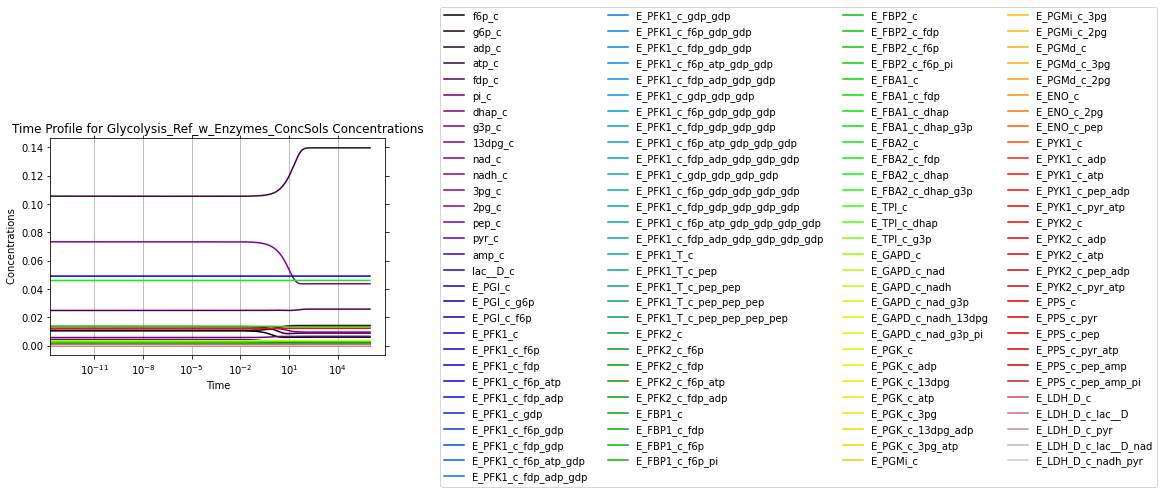

In [31]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_w_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol, flux_sol = sim.simulate(reference_model, time=(0, tfinal))
conc_sol.view_time_profile(plot_function="semilogx")


#### Save a reference MASS model w/ enzymes

In [32]:
conc_sol, flux_sol = sim.find_steady_state(
    models=reference_model, strategy="simulate", update_values=True,
    tfinal=tfinal)
if conc_sol and flux_sol:
    # Save a reference MASS model
    save_mass_json_model(
        mass_model=reference_model,
        filename=f"./models/mass/with_enzymes/{reference_model.id}.json")
    print(f"Saving {reference_model.id}")
reference_model

Saving Glycolysis_Ref_w_Enzymes


Name,Glycolysis_Ref_w_Enzymes
Memory address,0x01b692ddde50
Stoichiometric Matrix,120x121
Matrix Rank,102
Number of metabolites,120
Initial conditions defined,120/120
Number of reactions,121
Number of genes,19
Number of enzyme modules,17
Number of groups,0
Objective expression,0


## Simulate to steady state and export ensemble

In [ ]:
sim = Simulation(final_ensemble[0])
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9
sim.add_models(final_ensemble[1:], disable_safe_load=True)
for model in final_ensemble:
    # Attempt to determine steady state
    conc_sol, flux_sol = sim.find_steady_state(
        models=model, strategy="simulate", update_values=True,
        tfinal=tfinal)
    if conc_sol and flux_sol:
        # Save a reference MASS model
        save_mass_json_model(
            mass_model=model,
            filename=f"./models/mass/with_enzymes/{model.id}.json")
        print(f"Saving {model.id}")
    else:
        print(f"No steady state for {model.id}.")

Saving Glycolysis_C0
Saving Glycolysis_C1
Saving Glycolysis_C2
Saving Glycolysis_C3
Saving Glycolysis_C4


# Trying out things

In [37]:
from mass.io import json

In [38]:
model = json.load_json_model('models/mass/without_enzymes/Glycolysis_Ref_wo_Enzymes.json')

In [45]:
model.fixed

{<MassMetabolite h_c at 0x28dbe748c48>: 1,
 <MassMetabolite h2o_c at 0x28dbe748e48>: 1,
 <MassMetabolite gdp_c at 0x28dbea89ac8>: 0.00012133529512859641}

In [50]:
model.boundary_metabolites

['_3pg_b',
 'adp_b',
 'amp_b',
 'atp_b',
 'dhap_b',
 'f6p_b',
 'g3p_b',
 'g6p_b',
 'h2o_b',
 'h_b',
 'nad_b',
 'nadh_b',
 'pep_b',
 'pi_b',
 'pyr_b']

In [48]:
model.reactions

[<MassReaction PGI at 0x28dbe748888>,
 <MassReaction PFK at 0x28dbe7485c8>,
 <MassReaction FBP at 0x28dbe748388>,
 <MassReaction FBA at 0x28dbe7450c8>,
 <MassReaction TPI at 0x28dbe734e88>,
 <MassReaction GAPD at 0x28dbe730488>,
 <MassReaction PGK at 0x28dbe72cc88>,
 <MassReaction PGM at 0x28dbe72c2c8>,
 <MassReaction ENO at 0x28dbe72a288>,
 <MassReaction PYK at 0x28dbe734848>,
 <MassReaction PPS at 0x28dbe721e08>,
 <MassReaction LDH_D at 0x28dbe714b08>,
 <MassReaction SK_f6p_c at 0x28dbe714a08>,
 <MassReaction SK_g6p_c at 0x28dbe712408>,
 <MassReaction SK_adp_c at 0x28dbe712748>,
 <MassReaction SK_atp_c at 0x28dbe710648>,
 <MassReaction SK_h_c at 0x28dbe710848>,
 <MassReaction SK_h2o_c at 0x28dbe710888>,
 <MassReaction SK_pi_c at 0x28dbe7100c8>,
 <MassReaction SK_dhap_c at 0x28dbe70d948>,
 <MassReaction SK_g3p_c at 0x28dbe70dec8>,
 <MassReaction SK_nad_c at 0x28dbe70d2c8>,
 <MassReaction SK_nadh_c at 0x28dbe709588>,
 <MassReaction SK__3pg_c at 0x28dbe709f08>,
 <MassReaction SK_pep_c a

In [51]:
model.sinks

[<MassReaction SK_f6p_c at 0x28dbe714a08>,
 <MassReaction SK_g6p_c at 0x28dbe712408>,
 <MassReaction SK_adp_c at 0x28dbe712748>,
 <MassReaction SK_atp_c at 0x28dbe710648>,
 <MassReaction SK_h_c at 0x28dbe710848>,
 <MassReaction SK_h2o_c at 0x28dbe710888>,
 <MassReaction SK_pi_c at 0x28dbe7100c8>,
 <MassReaction SK_dhap_c at 0x28dbe70d948>,
 <MassReaction SK_g3p_c at 0x28dbe70dec8>,
 <MassReaction SK_nad_c at 0x28dbe70d2c8>,
 <MassReaction SK_nadh_c at 0x28dbe709588>,
 <MassReaction SK__3pg_c at 0x28dbe709f08>,
 <MassReaction SK_pep_c at 0x28dbe709888>,
 <MassReaction SK_pyr_c at 0x28dbe884ec8>,
 <MassReaction SK_amp_c at 0x28dbe884948>]

In [52]:
model.metabolites

[<MassMetabolite f6p_c at 0x28dbe748908>,
 <MassMetabolite g6p_c at 0x28dbe7487c8>,
 <MassMetabolite adp_c at 0x28dbe748788>,
 <MassMetabolite atp_c at 0x28dbe748688>,
 <MassMetabolite fdp_c at 0x28dbe7486c8>,
 <MassMetabolite h_c at 0x28dbe748c48>,
 <MassMetabolite h2o_c at 0x28dbe748e48>,
 <MassMetabolite pi_c at 0x28dbe748648>,
 <MassMetabolite dhap_c at 0x28dbea730c8>,
 <MassMetabolite g3p_c at 0x28dbead6048>,
 <MassMetabolite _13dpg_c at 0x28dba227b48>,
 <MassMetabolite nad_c at 0x28dbea79708>,
 <MassMetabolite nadh_c at 0x28dbeb18b08>,
 <MassMetabolite _3pg_c at 0x28dbeacc8c8>,
 <MassMetabolite _2pg_c at 0x28dbeacc9c8>,
 <MassMetabolite pep_c at 0x28dbeacc748>,
 <MassMetabolite pyr_c at 0x28dbeacc048>,
 <MassMetabolite amp_c at 0x28dbeacc588>,
 <MassMetabolite lac__D_c at 0x28dbeb66e48>,
 <MassMetabolite gdp_c at 0x28dbea89ac8>]

In [58]:
model.odes

{<MassMetabolite f6p_c at 0x28dbe748908>: 1.0*kf_FBP*(fdp_c(t) - f6p_c(t)*pi_c(t)/Keq_FBP) - 1.0*kf_PFK*(atp_c(t)*f6p_c(t) - adp_c(t)*fdp_c(t)/Keq_PFK) + 1.0*kf_PGI*(g6p_c(t) - f6p_c(t)/Keq_PGI) + kf_SK_f6p_c*(f6p_b - f6p_c(t)/Keq_SK_f6p_c),
 <MassMetabolite g6p_c at 0x28dbe7487c8>: -1.0*kf_PGI*(g6p_c(t) - f6p_c(t)/Keq_PGI) - kf_SK_g6p_c*(g6p_c(t) - g6p_b/Keq_SK_g6p_c),
 <MassMetabolite adp_c at 0x28dbe748788>: 1.0*kf_PFK*(atp_c(t)*f6p_c(t) - adp_c(t)*fdp_c(t)/Keq_PFK) + 1.0*kf_PGK*(_3pg_c(t)*atp_c(t) - _13dpg_c(t)*adp_c(t)/Keq_PGK) - 1.0*kf_PYK*(adp_c(t)*pep_c(t) - atp_c(t)*pyr_c(t)/Keq_PYK) + kf_SK_adp_c*(adp_b - adp_c(t)/Keq_SK_adp_c),
 <MassMetabolite atp_c at 0x28dbe748688>: -1.0*kf_PFK*(atp_c(t)*f6p_c(t) - adp_c(t)*fdp_c(t)/Keq_PFK) - 1.0*kf_PGK*(_3pg_c(t)*atp_c(t) - _13dpg_c(t)*adp_c(t)/Keq_PGK) - 1.0*kf_PPS*(atp_c(t)*pyr_c(t) - amp_c(t)*pep_c(t)*pi_c(t)/Keq_PPS) + 1.0*kf_PYK*(adp_c(t)*pep_c(t) - atp_c(t)*pyr_c(t)/Keq_PYK) - kf_SK_atp_c*(atp_c(t) - atp_b/Keq_SK_atp_c),
 <MassMet

In [59]:
sim = Simulation(reference_model=model)

In [60]:
sim.reference_model

Name,Glycolysis_Ref_wo_Enzymes
Memory address,0x028dbe74d9c8
Stoichiometric Matrix,20x27
Matrix Rank,19
Number of metabolites,20
Initial conditions defined,20/20
Number of reactions,27
Number of genes,19
Number of enzyme modules,0
Number of groups,0
Objective expression,0


In [61]:
initial_conditions, parameters = sim.get_model_simulation_values(model)
for metabolite, initial_condition in initial_conditions.items():
    print("{0}: {1}".format(metabolite, initial_condition))

f6p_c: 0.005184557512080841
g6p_c: 0.013134933905715226
adp_c: 0.007709383339362169
atp_c: 0.14617021826703305
fdp_c: 0.02422668389073643
h_c: 1
h2o_c: 1
pi_c: 0.00245343759310554
dhap_c: 0.006016857336303249
g3p_c: 0.0006832521213734147
_13dpg_c: 0.00015359817015413196
nad_c: 0.03816091725953881
nadh_c: 7.334111737554356e-05
_3pg_c: 0.006979989131857948
_2pg_c: 0.0010832375016517457
pep_c: 0.001767477494832261
pyr_c: 0.00028908822776717454
amp_c: 0.001579634961678699
lac__D_c: 0.0023192730469391585
gdp_c: 0.00012133529512859641


In [62]:
solutions = sim.simulate(model, time=(0,100))
solutions

(<MassSolution Glycolysis_Ref_wo_Enzymes_ConcSols at 0x28db6f0f588>,
 <MassSolution Glycolysis_Ref_wo_Enzymes_FluxSols at 0x28db6f0f648>)

In [77]:
conc_sol, flux_sol = solutions

# List the first 5 points of concentration solutions
for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution[:5]))

f6p_c: [0.00518456 0.00518456 0.00518456 0.00518456]
g6p_c: [0.01313493 0.01313493 0.01313493 0.01313493]
adp_c: [0.00770938 0.00770938 0.00770938 0.00770938]
atp_c: [0.14617022 0.14617022 0.14617022 0.14617022]
fdp_c: [0.02422668 0.02422668 0.02422668 0.02422668]
pi_c: [0.00245344 0.00245344 0.00245344 0.00245344]
dhap_c: [0.00601686 0.00601686 0.00601686 0.00601686]
g3p_c: [0.00068325 0.00068325 0.00068325 0.00068325]
_13dpg_c: [0.0001536 0.0001536 0.0001536 0.0001536]
nad_c: [0.03816092 0.03816092 0.03816092 0.03816092]
nadh_c: [7.33411174e-05 7.33411174e-05 7.33411174e-05 7.33411174e-05]
_3pg_c: [0.00697999 0.00697999 0.00697999 0.00697999]
_2pg_c: [0.00108324 0.00108324 0.00108324 0.00108324]
pep_c: [0.00176748 0.00176748 0.00176748 0.00176748]
pyr_c: [0.00028909 0.00028909 0.00028909 0.00028909]
amp_c: [0.00157963 0.00157963 0.00157963 0.00157963]
lac__D_c: [0.00231927 0.00231927 0.00231927 0.00231927]


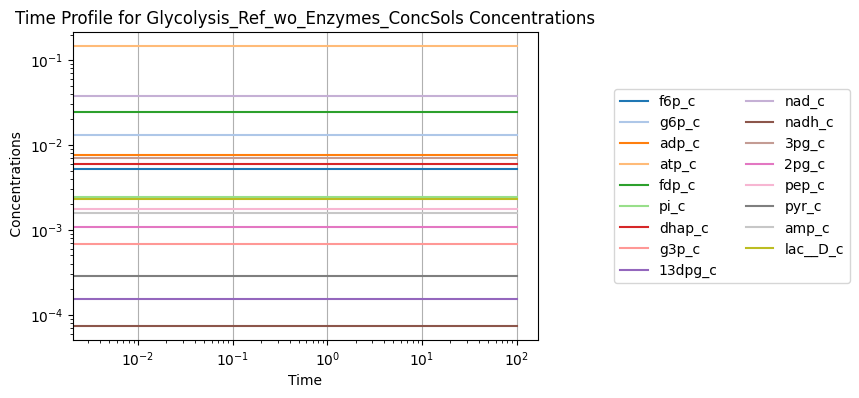

In [78]:
conc_sol.view_time_profile()

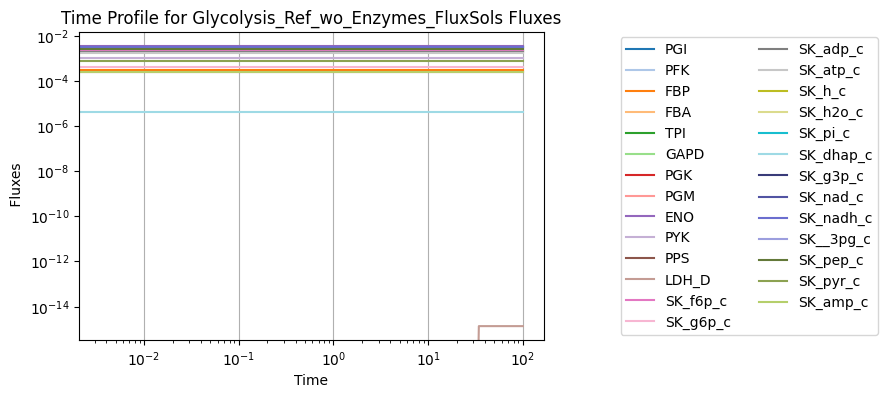

In [79]:
flux_sol.view_time_profile()

In [69]:
sim.reference_model.fixed

{<MassMetabolite h_c at 0x28dbe748c48>: 1,
 <MassMetabolite h2o_c at 0x28dbe748e48>: 1,
 <MassMetabolite gdp_c at 0x28dbea89ac8>: 0.00012133529512859641}

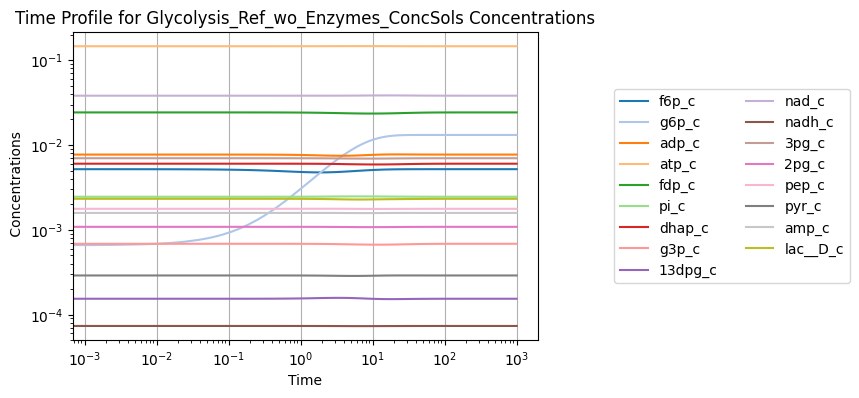

In [72]:
conc_sol, flux_sol = sim.simulate(
    model, time=(0, 1000), perturbations={"g6p_c": "g6p_c * 0.05"})
conc_sol.view_time_profile()

In [14]:
for reaction, rate in model.rates.items():
    print("{0}: {1}".format(reaction.id, rate))

PGI: kf_PGI*(g6p_c(t) - f6p_c(t)/Keq_PGI)
PFK: kf_PFK*(atp_c(t)*f6p_c(t) - adp_c(t)*fdp_c(t)/Keq_PFK)
FBP: kf_FBP*(fdp_c(t) - f6p_c(t)*pi_c(t)/Keq_FBP)
FBA: kf_FBA*(fdp_c(t) - dhap_c(t)*g3p_c(t)/Keq_FBA)
TPI: kf_TPI*(dhap_c(t) - g3p_c(t)/Keq_TPI)
GAPD: kf_GAPD*(g3p_c(t)*nad_c(t)*pi_c(t) - _13dpg_c(t)*nadh_c(t)/Keq_GAPD)
PGK: kf_PGK*(_3pg_c(t)*atp_c(t) - _13dpg_c(t)*adp_c(t)/Keq_PGK)
PGM: kf_PGM*(_2pg_c(t) - _3pg_c(t)/Keq_PGM)
ENO: kf_ENO*(_2pg_c(t) - pep_c(t)/Keq_ENO)
PYK: kf_PYK*(adp_c(t)*pep_c(t) - atp_c(t)*pyr_c(t)/Keq_PYK)
PPS: kf_PPS*(atp_c(t)*pyr_c(t) - amp_c(t)*pep_c(t)*pi_c(t)/Keq_PPS)
LDH_D: kf_LDH_D*(lac__D_c(t)*nad_c(t) - nadh_c(t)*pyr_c(t)/Keq_LDH_D)
SK_f6p_c: kf_SK_f6p_c*(f6p_b - f6p_c(t)/Keq_SK_f6p_c)
SK_g6p_c: kf_SK_g6p_c*(g6p_c(t) - g6p_b/Keq_SK_g6p_c)
SK_adp_c: kf_SK_adp_c*(adp_b - adp_c(t)/Keq_SK_adp_c)
SK_atp_c: kf_SK_atp_c*(atp_c(t) - atp_b/Keq_SK_atp_c)
SK_h_c: kf_SK_h_c*(h_c - h_b/Keq_SK_h_c)
SK_h2o_c: kf_SK_h2o_c*(h2o_c - h2o_b/Keq_SK_h2o_c)
SK_pi_c: kf_SK_pi_c*(

# Constructing glycolysis

In [351]:
from os import path

import matplotlib.pyplot as plt

from cobra import DictList

from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io import json, sbml
from mass.util import qcqa_model

mass_config = MassConfiguration()

In [352]:
glycolysis = MassModel("Glycolysis")

In [353]:
glc__D_c = MassMetabolite(
    "glc__D_c",
    name="D-Glucose",
    formula="C6H12O6",
    charge=0,
    compartment="c",
    fixed=False)

g6p_c = MassMetabolite(
    "g6p_c",
    name="D-Glucose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c",
    fixed=False)

f6p_c = MassMetabolite(
    "f6p_c",
    name="D-Fructose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c",
    fixed=False)

fdp_c = MassMetabolite(
    "fdp_c",
    name="D-Fructose 1,6-bisphosphate",
    formula="C6H10O12P2",
    charge=-4,
    compartment="c",
    fixed=False)

dhap_c = MassMetabolite(
    "dhap_c",
    name="Dihydroxyacetone phosphate",
    formula="C3H5O6P",
    charge=-2,
    compartment="c",
    fixed=False)

g3p_c = MassMetabolite(
    "g3p_c",
    name="Glyceraldehyde 3-phosphate",
    formula="C3H5O6P",
    charge=-2,
    compartment="c",
    fixed=False)

_13dpg_c = MassMetabolite(
    "_13dpg_c",
    name="3-Phospho-D-glyceroyl phosphate",
    formula="C3H4O10P2",
    charge=-4,
    compartment="c",
    fixed=False)

_3pg_c = MassMetabolite(
    "_3pg_c",
    name="3-Phospho-D-glycerate",
    formula="C3H4O7P",
    charge=-3,
    compartment="c",
    fixed=False)

_2pg_c = MassMetabolite(
    "_2pg_c",
    name="D-Glycerate 2-phosphate",
    formula="C3H4O7P",
    charge=-3,
    compartment="c",
    fixed=False)

pep_c = MassMetabolite(
    "pep_c",
    name="Phosphoenolpyruvate",
    formula="C3H2O6P",
    charge=-3,
    compartment="c",
    fixed=False)

pyr_c = MassMetabolite(
    "pyr_c",
    name="Pyruvate",
    formula="C3H3O3",
    charge=-1,
    compartment="c",
    fixed=False)

lac__L_c = MassMetabolite(
    "lac__L_c",
    name="L-Lactate",
    formula="C3H5O3",
    charge=-1,
    compartment="c",
    fixed=False)

nad_c = MassMetabolite(
    "nad_c",
    name="Nicotinamide adenine dinucleotide",
    formula="[NAD]-C21H26N7O14P2",
    charge=-1,
    compartment="c",
    fixed=False)

nadh_c = MassMetabolite(
    "nadh_c",
    name="Nicotinamide adenine dinucleotide - reduced",
    formula="[NAD]-C21H27N7O14P2",
    charge=-2,
    compartment="c",
    fixed=False)

atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c",
    fixed=False)

adp_c = MassMetabolite(
    "adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c",
    fixed=False)

amp_c = MassMetabolite(
    "amp_c",
    name="AMP",
    formula="C10H12N5O7P",
    charge=-2,
    compartment="c",
    fixed=False)

pi_c = MassMetabolite(
    "pi_c",
    name="Phosphate",
    formula="HPO4",
    charge=-2,
    compartment="c",
    fixed=False)

h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c",
    fixed=False)

h2o_c = MassMetabolite(
    "h2o_c",
    name="H2O",
    formula="H2O",
    charge=0,
    compartment="c",
    fixed=False)

In [354]:
HEX1 = MassReaction(
    "HEX1",
    name="Hexokinase (D-glucose:ATP)",
    subsystem=glycolysis.id,
    reversible=True)
HEX1.add_metabolites({
    glc__D_c: -1,
    atp_c: -1,
    adp_c: 1,
    g6p_c: 1,
    h_c: 1})

PGI = MassReaction(
    "PGI",
    name="Glucose-6-phosphate isomerase",
    subsystem=glycolysis.id,
    reversible=True)
PGI.add_metabolites({
    g6p_c: -1,
    f6p_c: 1})

PFK = MassReaction(
    "PFK",
    name="Phosphofructokinase",
    subsystem=glycolysis.id,
    reversible=True)
PFK.add_metabolites({
    f6p_c: -1,
    atp_c: -1,
    fdp_c: 1,
    adp_c: 1,
    h_c: 1})

FBA = MassReaction(
    "FBA",
    name="Fructose-bisphosphate aldolase",
    subsystem=glycolysis.id,
    reversible=True)
FBA.add_metabolites({
    fdp_c: -1,
    dhap_c: 1,
    g3p_c: 1})

TPI = MassReaction(
    "TPI",
    name="Triose-phosphate isomerase",
    subsystem=glycolysis.id,
    reversible=True)
TPI.add_metabolites({
    dhap_c: -1,
    g3p_c: 1})

GAPD = MassReaction(
    "GAPD",
    name="Glyceraldehyde-3-phosphate dehydrogenase",
    subsystem=glycolysis.id,
    reversible=True)
GAPD.add_metabolites({
    g3p_c: -1,
    nad_c: -1,
    pi_c: -1,
    _13dpg_c: 1,
    h_c: 1,
    nadh_c: 1})

PGK = MassReaction(
    "PGK",
    name="Phosphoglycerate kinase",
    subsystem=glycolysis.id,
    reversible=True)
PGK.add_metabolites({
    _13dpg_c: -1,
    adp_c: -1,
    _3pg_c: 1,
    atp_c: 1})

PGM = MassReaction(
    "PGM",
    name="Phosphoglycerate mutase",
    subsystem=glycolysis.id,
    reversible=True)
PGM.add_metabolites({
    _3pg_c: -1,
    _2pg_c: 1})

ENO = MassReaction(
    "ENO",
    name="Enolase",
    subsystem=glycolysis.id,
    reversible=True)
ENO.add_metabolites({
    _2pg_c: -1,
    h2o_c: 1,
    pep_c: 1})

PYK = MassReaction(
    "PYK",
    name="Pyruvate kinase",
    subsystem=glycolysis.id,
    reversible=True)
PYK.add_metabolites({
    pep_c: -1,
    h_c: -1,
    adp_c: -1,
    atp_c: 1,
    pyr_c: 1})

LDH_L = MassReaction(
    "LDH_L",
    name="L-lactate dehydrogenase",
    subsystem=glycolysis.id,
    reversible=True)
LDH_L.add_metabolites({
    h_c: -1,
    nadh_c: -1,
    pyr_c: -1,
    lac__L_c: 1,
    nad_c: 1})

ADK1 = MassReaction(
    "ADK1",
    name="Adenylate kinase",
    subsystem="Misc.",
    reversible=True)
ADK1.add_metabolites({
    adp_c: -2,
    amp_c: 1,
    atp_c: 1})

ATPM = MassReaction(
    "ATPM",
    name="ATP maintenance requirement",
    subsystem="Pseudoreaction",
    reversible=False)
ATPM.add_metabolites({
    atp_c: -1,
    h2o_c: -1,
    adp_c: 1,
    h_c: 1,
    pi_c: 1})

DM_nadh = MassReaction(
    "DM_nadh",
    name="Demand NADH",
    subsystem="Pseudoreaction",
    reversible=False)
DM_nadh.add_metabolites({
    nadh_c: -1,
    nad_c: 1,
    h_c: 1})

In [355]:
glycolysis.add_reactions([
    HEX1, PGI, PFK, FBA, TPI, GAPD, PGK,
    PGM, ENO, PYK, LDH_L, ADK1, ATPM, DM_nadh])

for reaction in glycolysis.reactions:
    print(reaction)

HEX1: atp_c + glc__D_c <=> adp_c + g6p_c + h_c
PGI: g6p_c <=> f6p_c
PFK: atp_c + f6p_c <=> adp_c + fdp_c + h_c
FBA: fdp_c <=> dhap_c + g3p_c
TPI: dhap_c <=> g3p_c
GAPD: g3p_c + nad_c + pi_c <=> _13dpg_c + h_c + nadh_c
PGK: _13dpg_c + adp_c <=> _3pg_c + atp_c
PGM: _3pg_c <=> _2pg_c
ENO: _2pg_c <=> h2o_c + pep_c
PYK: adp_c + h_c + pep_c <=> atp_c + pyr_c
LDH_L: h_c + nadh_c + pyr_c <=> lac__L_c + nad_c
ADK1: 2 adp_c <=> amp_c + atp_c
ATPM: atp_c + h2o_c --> adp_c + h_c + pi_c
DM_nadh: nadh_c --> h_c + nad_c


In [356]:
SK_glc__D_c = glycolysis.add_boundary(
    metabolite=glc__D_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_glc__D_c.reverse_stoichiometry(inplace=True)

SK_lac__L_c = glycolysis.add_boundary(
    metabolite=lac__L_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_pyr_c = glycolysis.add_boundary(
    metabolite=pyr_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=0.06)

SK_h_c = glycolysis.add_boundary(
    metabolite=h_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=6.30957e-05)

SK_h2o_c = glycolysis.add_boundary(
    metabolite=h2o_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_amp_c = glycolysis.add_boundary(
    metabolite=amp_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_amp_c.reverse_stoichiometry(inplace=True)

DM_amp_c = glycolysis.add_boundary(
    metabolite=amp_c, boundary_type="demand", subsystem="Pseudoreaction",
    boundary_condition=1)

print("Boundary Reactions and Values\n-----------------------------")
for reaction in glycolysis.boundary:
    boundary_met = reaction.boundary_metabolite
    bc_value = glycolysis.boundary_conditions.get(boundary_met)
    print("{0}\n{1}: {2}\n".format(
        reaction, boundary_met, bc_value))

Boundary Reactions and Values
-----------------------------
SK_glc__D_c:  <=> glc__D_c
glc__D_b: 1.0

SK_lac__L_c: lac__L_c <=> 
lac__L_b: 1.0

SK_pyr_c: pyr_c <=> 
pyr_b: 0.06

SK_h_c: h_c <=> 
h_b: 6.30957e-05

SK_h2o_c: h2o_c <=> 
h2o_b: 1.0

SK_amp_c:  <=> amp_c
amp_b: 1.0

DM_amp_c: amp_c --> 
amp_b: 1.0



In [357]:
new_metabolite_order = [
    "glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c",
    "g3p_c", "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c",
    "pyr_c", "lac__L_c", "nad_c", "nadh_c", "amp_c",
    "adp_c", "atp_c", "pi_c", "h_c", "h2o_c"]

if len(glycolysis.metabolites) == len(new_metabolite_order):
    glycolysis.metabolites = DictList(
        glycolysis.metabolites.get_by_any(new_metabolite_order))

new_reaction_order = [
    "HEX1", "PGI", "PFK", "FBA", "TPI",
    "GAPD", "PGK", "PGM", "ENO", "PYK",
    "LDH_L", "DM_amp_c", "ADK1", "SK_pyr_c",
    "SK_lac__L_c", "ATPM", "DM_nadh", "SK_glc__D_c",
    "SK_amp_c", "SK_h_c", "SK_h2o_c"]

if len(glycolysis.reactions) == len(new_reaction_order):
    glycolysis.reactions = DictList(
        glycolysis.reactions.get_by_any(new_reaction_order))

glycolysis.update_S(array_type="DataFrame", dtype=int)

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,...,DM_amp_c,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_amp_c,SK_h_c,SK_h2o_c
glc__D_c,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
g6p_c,1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f6p_c,0,1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fdp_c,0,0,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dhap_c,0,0,0,1,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g3p_c,0,0,0,1,1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_13dpg_c,0,0,0,0,0,1,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_3pg_c,0,0,0,0,0,0,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
_2pg_c,0,0,0,0,0,0,0,1,-1,0,...,0,0,0,0,0,0,0,0,0,0
pep_c,0,0,0,0,0,0,0,0,1,-1,...,0,0,0,0,0,0,0,0,0,0


In [358]:
minspan_paths = [
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, -1, 0, 1, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
glycolysis.compute_steady_state_fluxes(
    pathways=minspan_paths,
    independent_fluxes={
        SK_glc__D_c: 1.12,
        DM_nadh: .2 * 1.12,
        DM_amp_c: 0.014},
    update_reactions=True)

print("Steady State Fluxes\n-------------------")
for reaction, steady_state_flux in glycolysis.steady_state_fluxes.items():
    print("{0}: {1:.6f}".format(reaction.flux_symbol_str, steady_state_flux))

Steady State Fluxes
-------------------
v_HEX1: 1.120000
v_PGI: 1.120000
v_PFK: 1.120000
v_FBA: 1.120000
v_TPI: 1.120000
v_GAPD: 2.240000
v_PGK: 2.240000
v_PGM: 2.240000
v_ENO: 2.240000
v_PYK: 2.240000
v_LDH_L: 2.016000
v_DM_amp_c: 0.014000
v_ADK1: 0.000000
v_SK_pyr_c: 0.224000
v_SK_lac__L_c: 2.016000
v_ATPM: 2.240000
v_DM_nadh: 0.224000
v_SK_glc__D_c: 1.120000
v_SK_amp_c: 0.014000
v_SK_h_c: 2.688000
v_SK_h2o_c: 0.000000


In [359]:
glc__D_c.ic = 1.0
g6p_c.ic = 0.0486
f6p_c.ic = 0.0198
fdp_c.ic = 0.0146
g3p_c.ic = 0.00728
dhap_c.ic = 0.16
_13dpg_c.ic = 0.000243
_3pg_c.ic = 0.0773
_2pg_c.ic = 0.0113
pep_c.ic = 0.017
pyr_c.ic = 0.060301
lac__L_c.ic = 1.36
atp_c.ic = 1.6
adp_c.ic = 0.29
amp_c.ic = 0.0867281
h_c.ic = 0.0000899757
nad_c.ic = 0.0589
nadh_c.ic = 0.0301
pi_c.ic = 2.5
h2o_c.ic = 1.0

print("Initial Conditions\n------------------")
for metabolite, ic_value in glycolysis.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
glc__D_c: 1.0
g6p_c: 0.0486
f6p_c: 0.0198
fdp_c: 0.0146
dhap_c: 0.16
g3p_c: 0.00728
_13dpg_c: 0.000243
_3pg_c: 0.0773
_2pg_c: 0.0113
pep_c: 0.017
pyr_c: 0.060301
lac__L_c: 1.36
nad_c: 0.0589
nadh_c: 0.0301
amp_c: 0.0867281
adp_c: 0.29
atp_c: 1.6
pi_c: 2.5
h_c: 8.99757e-05
h2o_c: 1.0


In [360]:
HEX1.Keq = 850
PGI.Keq = 0.41
PFK.Keq = 310
FBA.Keq = 0.082
TPI.Keq = 0.0571429
GAPD.Keq = 0.0179
PGK.Keq = 1800
PGM.Keq = 0.147059
ENO.Keq = 1.69492
PYK.Keq = 363000
LDH_L.Keq = 26300
ADK1.Keq = 1.65

SK_glc__D_c.Keq = mass_config.irreversible_Keq
SK_lac__L_c.Keq = 1
SK_pyr_c.Keq = 1
SK_h_c.Keq = 1
SK_h2o_c.Keq = 1
SK_amp_c.Keq = mass_config.irreversible_Keq

print("Equilibrium Constants\n---------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

Equilibrium Constants
---------------------
Keq_HEX1: 850
Keq_PGI: 0.41
Keq_PFK: 310
Keq_FBA: 0.082
Keq_TPI: 0.0571429
Keq_GAPD: 0.0179
Keq_PGK: 1800
Keq_PGM: 0.147059
Keq_ENO: 1.69492
Keq_PYK: 363000
Keq_LDH_L: 26300
Keq_DM_amp_c: inf
Keq_ADK1: 1.65
Keq_SK_pyr_c: 1
Keq_SK_lac__L_c: 1
Keq_ATPM: inf
Keq_DM_nadh: inf
Keq_SK_glc__D_c: inf
Keq_SK_amp_c: inf
Keq_SK_h_c: 1
Keq_SK_h2o_c: 1


In [361]:
glycolysis.calculate_PERCs(update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_HEX1: 0.700007
kf_PGI: 3644.444444
kf_PFK: 35.368784
kf_FBA: 2834.567901
kf_TPI: 34.355728
kf_GAPD: 3376.749242
kf_PGK: 1273531.269741
kf_PGM: 4868.589299
kf_ENO: 1763.740525
kf_PYK: 454.385552
kf_LDH_L: 1112.573989
kf_DM_amp_c: 0.161424
kf_ADK1: 100000.000000
kf_SK_pyr_c: 744.186047
kf_SK_lac__L_c: 5.600000
kf_ATPM: 1.400000
kf_DM_nadh: 7.441860
kf_SK_glc__D_c: 1.120000
kf_SK_amp_c: 0.014000
kf_SK_h_c: 100000.000000
kf_SK_h2o_c: 100000.000000


In [362]:
qcqa_model(glycolysis, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: Glycolysis                         │
│ SIMULATABLE: True                            │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ ----------------------                       │
│ DM_nadh: {charge: 2.0}                       │
│ ============================================ │
╘══════════════════════════════════════════════╛


Successfully loaded MassModel 'Glycolysis' into RoadRunner.


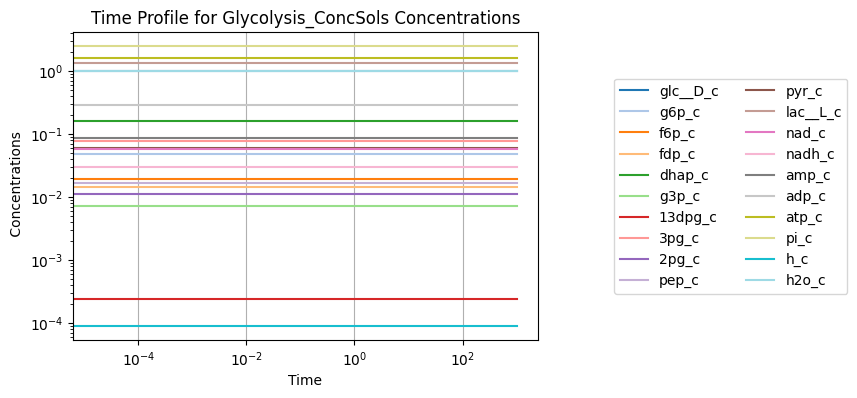

In [363]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [364]:
glycolysis.compartments = {"c": "Cytosol"}
print(glycolysis.compartments)

{'c': 'Cytosol'}


In [365]:
# Using pre-build units to define UnitDefinitions
concentration = UnitDefinition("mM", name="Millimolar", list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

# Add units to model
glycolysis.add_units([concentration, time])
print(glycolysis.units)

[<UnitDefinition Millimolar "mM" at 0x28dc6399888>, <UnitDefinition hour "hr" at 0x28dc6399bc8>]


In [366]:
json.save_json_model(glycolysis, filename=glycolysis.id + ".json")

Successfully loaded MassModel 'Glycolysis' into RoadRunner.


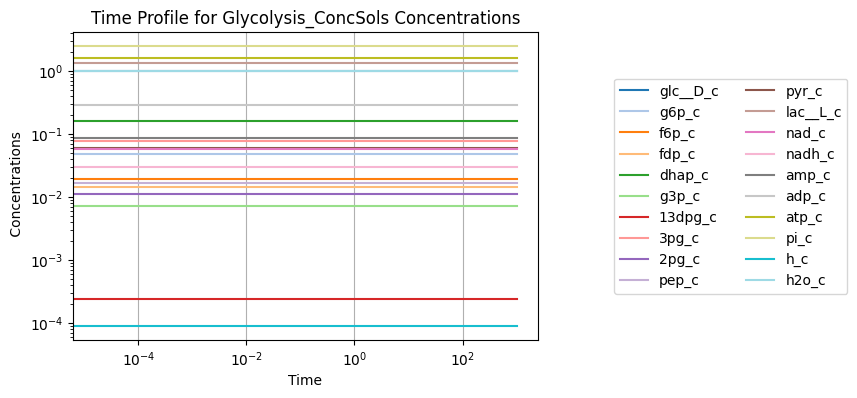

In [367]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [368]:
flux_sol.SK_glc__D_c

array([1.12, 1.12, 1.12, 1.12, 1.12, 1.12, 1.12, 1.12, 1.12, 1.12, 1.12,
       1.12, 1.12, 1.12, 1.12, 1.12])

In [369]:
sim.reference_model.initial_conditions

{<MassMetabolite glc__D_c at 0x28dbe29cd48>: 1.0,
 <MassMetabolite g6p_c at 0x28dbe29ca48>: 0.0486,
 <MassMetabolite f6p_c at 0x28dc5c3dd48>: 0.0198,
 <MassMetabolite fdp_c at 0x28dc5c3d688>: 0.0146,
 <MassMetabolite dhap_c at 0x28dc5c3d808>: 0.16,
 <MassMetabolite g3p_c at 0x28dc5c3d908>: 0.00728,
 <MassMetabolite _13dpg_c at 0x28dc5c3d188>: 0.000243,
 <MassMetabolite _3pg_c at 0x28dc5c3d648>: 0.0773,
 <MassMetabolite _2pg_c at 0x28dc5c3d388>: 0.0113,
 <MassMetabolite pep_c at 0x28dc5c3d148>: 0.017,
 <MassMetabolite pyr_c at 0x28dc5c3dc48>: 0.060301,
 <MassMetabolite lac__L_c at 0x28dc5c3d288>: 1.36,
 <MassMetabolite nad_c at 0x28dc5c3d8c8>: 0.0589,
 <MassMetabolite nadh_c at 0x28dc5c3df88>: 0.0301,
 <MassMetabolite amp_c at 0x28dc5c3da08>: 0.0867281,
 <MassMetabolite adp_c at 0x28dc5c3d508>: 0.29,
 <MassMetabolite atp_c at 0x28dc5c3d748>: 1.6,
 <MassMetabolite pi_c at 0x28dc5c3d048>: 2.5,
 <MassMetabolite h_c at 0x28dc5c3dec8>: 8.99757e-05,
 <MassMetabolite h2o_c at 0x28dc5c3d448>: 1

In [370]:
conc_sol.glc__D_c

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Successfully loaded MassModel 'Glycolysis' into RoadRunner.


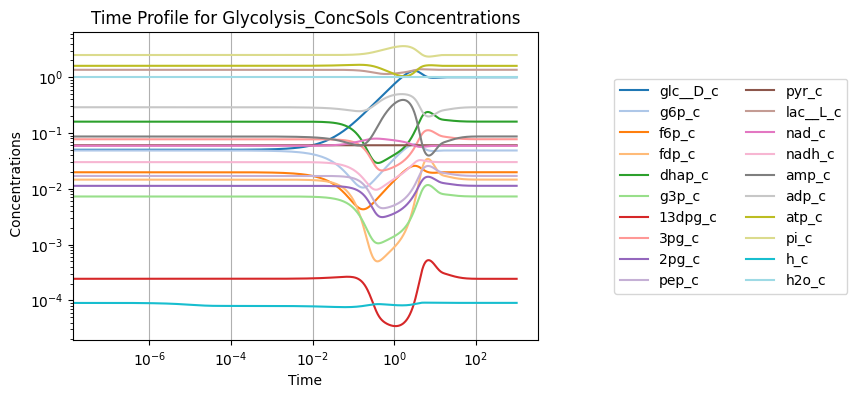

In [371]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3), perturbations={"glc__D_c": "glc__D_c * 0.05"})
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [372]:
sim.reference_model.rates

{<MassReaction HEX1 at 0x28dc5c23148>: kf_HEX1*(atp_c(t)*glc__D_c(t) - adp_c(t)*g6p_c(t)/Keq_HEX1),
 <MassReaction PGI at 0x28dc5c23bc8>: kf_PGI*(g6p_c(t) - f6p_c(t)/Keq_PGI),
 <MassReaction PFK at 0x28dc5c23ec8>: kf_PFK*(atp_c(t)*f6p_c(t) - adp_c(t)*fdp_c(t)/Keq_PFK),
 <MassReaction FBA at 0x28dc5c23cc8>: kf_FBA*(fdp_c(t) - dhap_c(t)*g3p_c(t)/Keq_FBA),
 <MassReaction TPI at 0x28db6dbd2c8>: kf_TPI*(dhap_c(t) - g3p_c(t)/Keq_TPI),
 <MassReaction GAPD at 0x28dbe502148>: kf_GAPD*(g3p_c(t)*nad_c(t)*pi_c(t) - _13dpg_c(t)*nadh_c(t)/Keq_GAPD),
 <MassReaction PGK at 0x28dbe502688>: kf_PGK*(_13dpg_c(t)*adp_c(t) - _3pg_c(t)*atp_c(t)/Keq_PGK),
 <MassReaction PGM at 0x28dbe502388>: kf_PGM*(_3pg_c(t) - _2pg_c(t)/Keq_PGM),
 <MassReaction ENO at 0x28dbe502d08>: kf_ENO*(_2pg_c(t) - pep_c(t)/Keq_ENO),
 <MassReaction PYK at 0x28dbe502888>: kf_PYK*(adp_c(t)*pep_c(t) - atp_c(t)*pyr_c(t)/Keq_PYK),
 <MassReaction LDH_L at 0x28dbe502408>: kf_LDH_L*(nadh_c(t)*pyr_c(t) - lac__L_c(t)*nad_c(t)/Keq_LDH_L),
 <MassR

In [373]:
sim.reference_model.reactions

[<MassReaction HEX1 at 0x28dc5c23148>,
 <MassReaction PGI at 0x28dc5c23bc8>,
 <MassReaction PFK at 0x28dc5c23ec8>,
 <MassReaction FBA at 0x28dc5c23cc8>,
 <MassReaction TPI at 0x28db6dbd2c8>,
 <MassReaction GAPD at 0x28dbe502148>,
 <MassReaction PGK at 0x28dbe502688>,
 <MassReaction PGM at 0x28dbe502388>,
 <MassReaction ENO at 0x28dbe502d08>,
 <MassReaction PYK at 0x28dbe502888>,
 <MassReaction LDH_L at 0x28dbe502408>,
 <MassReaction DM_amp_c at 0x28dc5c2adc8>,
 <MassReaction ADK1 at 0x28dbe5021c8>,
 <MassReaction SK_pyr_c at 0x28dc5fbff08>,
 <MassReaction SK_lac__L_c at 0x28dc2f38c48>,
 <MassReaction ATPM at 0x28dbe502d48>,
 <MassReaction DM_nadh at 0x28dbe502b88>,
 <MassReaction SK_glc__D_c at 0x28dc5c2ee08>,
 <MassReaction SK_amp_c at 0x28dc5c2a048>,
 <MassReaction SK_h_c at 0x28dc5c2a4c8>,
 <MassReaction SK_h2o_c at 0x28dc5c2a8c8>]

## Change the fluxes by changing the boundary condition of glucose

In [374]:
sim.reference_model.boundary_conditions.update({'glc__D_b':0.05})

In [375]:
sim.reference_model.boundary_conditions

{'glc__D_b': 0.05,
 'lac__L_b': 1.0,
 'pyr_b': 0.06,
 'h_b': 6.30957e-05,
 'h2o_b': 1.0,
 'amp_b': 1.0}

When the boundary is disturbed, the concentrations will dynamically change

Successfully loaded MassModel 'Glycolysis' into RoadRunner.


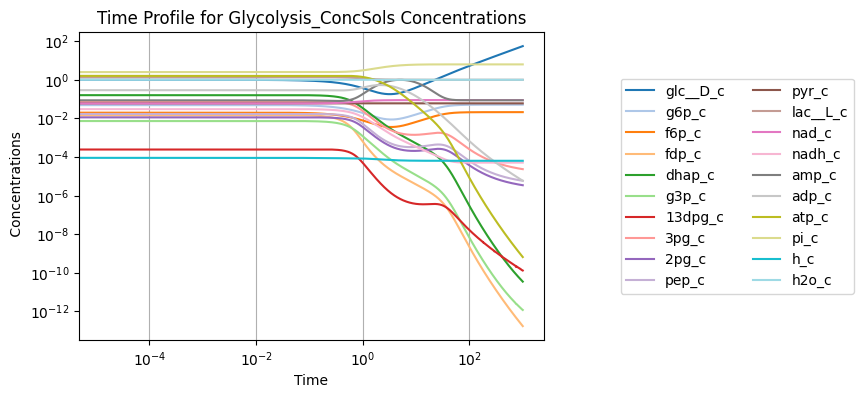

In [376]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [377]:
flux_sol.SK_glc__D_c

array([0.056, 0.056, 0.056, ..., 0.056, 0.056, 0.056])

In [378]:
flux_sol.HEX1

array([1.12000000e+00, 1.11998590e+00, 1.11997179e+00, ...,
       2.68490685e-08, 2.54958685e-08, 2.48354758e-08])

Final concentration values from the simulation  can be found and converted to dict like this

In [312]:
end_dict = conc_sol.to_frame().iloc[-1].to_dict()
end_dict

{'glc__D_c': 1.0000300003394311,
 'g6p_c': 0.048303201316345905,
 'f6p_c': 0.019791712469326005,
 'fdp_c': 4.927985022723768e-05,
 'dhap_c': 0.00571329640897091,
 'g3p_c': 0.00014018692695771812,
 '_13dpg_c': 2.3705296341467818e-05,
 '_3pg_c': 0.022477752930881344,
 '_2pg_c': 0.0032987897651552966,
 'pep_c': 0.005375924114377833,
 'pyr_c': 0.06003068354136547,
 'lac__L_c': 1.035922607400612,
 'nad_c': 0.0859316227866821,
 'nadh_c': 0.0030683772133180518,
 'amp_c': 0.08672741286028159,
 'adp_c': 0.09170556878115341,
 'atp_c': 0.1599996273105619,
 'pi_c': 5.844014342372136,
 'h_c': 6.579238562102186e-05,
 'h2o_c': 1.0000000000159814}

# update initial values with last values from previous simulation 

In [313]:
for idx, metabolite in enumerate(end_dict.keys()):
    sim.reference_model.metabolites[idx].ic = end_dict[metabolite]

In [314]:
sim.reference_model.ics

{<MassMetabolite glc__D_c at 0x28dc633e508>: 1.0000300003394311,
 <MassMetabolite g6p_c at 0x28dc633ef88>: 0.048303201316345905,
 <MassMetabolite f6p_c at 0x28dc638d0c8>: 0.019791712469326005,
 <MassMetabolite fdp_c at 0x28dc638dd08>: 4.927985022723768e-05,
 <MassMetabolite dhap_c at 0x28dc638d408>: 0.00571329640897091,
 <MassMetabolite g3p_c at 0x28dc638ddc8>: 0.00014018692695771812,
 <MassMetabolite _13dpg_c at 0x28dc638d348>: 2.3705296341467818e-05,
 <MassMetabolite _3pg_c at 0x28dc638d288>: 0.022477752930881344,
 <MassMetabolite _2pg_c at 0x28dc638d248>: 0.0032987897651552966,
 <MassMetabolite pep_c at 0x28dc638de08>: 0.005375924114377833,
 <MassMetabolite pyr_c at 0x28dc638d6c8>: 0.06003068354136547,
 <MassMetabolite lac__L_c at 0x28dc638d148>: 1.035922607400612,
 <MassMetabolite nad_c at 0x28dc638db08>: 0.0859316227866821,
 <MassMetabolite nadh_c at 0x28dc638d788>: 0.0030683772133180518,
 <MassMetabolite amp_c at 0x28dc5b603c8>: 0.08672741286028159,
 <MassMetabolite adp_c at 0x28

## Now that the initial values are changed, set the boundary to another value and run the sim again

In [330]:
sim.reference_model.boundary_conditions.update({'glc__D_b':0.3})

In [331]:
sim.reference_model.boundary_conditions

{'glc__D_b': 0.3,
 'lac__L_b': 1.0,
 'pyr_b': 0.06,
 'h_b': 6.30957e-05,
 'h2o_b': 1.0,
 'amp_b': 1.0}

Successfully loaded MassModel 'Glycolysis' into RoadRunner.


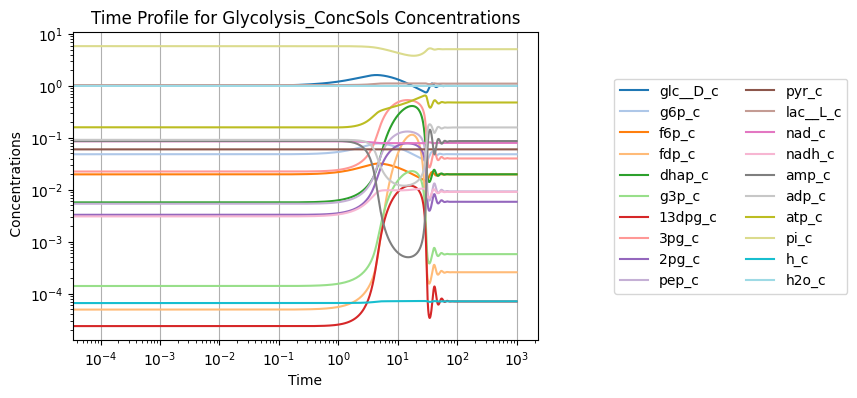

In [332]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [333]:
flux_sol.SK_glc__D_c

array([0.336, 0.336, 0.336, ..., 0.336, 0.336, 0.336])

In [334]:
conc_sol.glc__D_c

array([1.00003   , 1.00004728, 1.00008894, ..., 1.00000847, 1.00000847,
       1.00000847])

In [349]:
sim.reference_model.reactions.SK_glc__D_c.parameters

{'kf_SK_glc__D_c': 1.12, 'Keq_SK_glc__D_c': inf}

In [350]:
sim.reference_model.odes

{<MassMetabolite glc__D_c at 0x28dc633e508>: -kf_HEX1*(atp_c(t)*glc__D_c(t) - adp_c(t)*g6p_c(t)/Keq_HEX1) + kf_SK_glc__D_c*(glc__D_b - glc__D_c(t)/Keq_SK_glc__D_c),
 <MassMetabolite g6p_c at 0x28dc633ef88>: kf_HEX1*(atp_c(t)*glc__D_c(t) - adp_c(t)*g6p_c(t)/Keq_HEX1) - kf_PGI*(g6p_c(t) - f6p_c(t)/Keq_PGI),
 <MassMetabolite f6p_c at 0x28dc638d0c8>: -kf_PFK*(atp_c(t)*f6p_c(t) - adp_c(t)*fdp_c(t)/Keq_PFK) + kf_PGI*(g6p_c(t) - f6p_c(t)/Keq_PGI),
 <MassMetabolite fdp_c at 0x28dc638dd08>: -kf_FBA*(fdp_c(t) - dhap_c(t)*g3p_c(t)/Keq_FBA) + kf_PFK*(atp_c(t)*f6p_c(t) - adp_c(t)*fdp_c(t)/Keq_PFK),
 <MassMetabolite dhap_c at 0x28dc638d408>: kf_FBA*(fdp_c(t) - dhap_c(t)*g3p_c(t)/Keq_FBA) - kf_TPI*(dhap_c(t) - g3p_c(t)/Keq_TPI),
 <MassMetabolite g3p_c at 0x28dc638ddc8>: kf_FBA*(fdp_c(t) - dhap_c(t)*g3p_c(t)/Keq_FBA) - kf_GAPD*(g3p_c(t)*nad_c(t)*pi_c(t) - _13dpg_c(t)*nadh_c(t)/Keq_GAPD) + kf_TPI*(dhap_c(t) - g3p_c(t)/Keq_TPI),
 <MassMetabolite _13dpg_c at 0x28dc638d348>: kf_GAPD*(g3p_c(t)*nad_c(t)*pi_